In [1]:
import warnings
warnings.simplefilter("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import sklearn.datasets
#import sklearn.feature_extraction.text
#import sklearn.preprocessing
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
import scipy.sparse
import vectorizers
import vectorizers.transformers
import seaborn as sns
import igraph as ig
from scipy.sparse import vstack
sns.set()
import umap
import umap.plot
umap.plot.output_notebook()
from bokeh.plotting import show
from collections import Counter

import sklearn.model_selection
import sklearn.ensemble
import sklearn.linear_model
import sklearn.neural_network
import sklearn.neighbors


Loading BokehJS ...

# NCI Datasets

We build one large graph from 4000+ smaller ones (there are 2 datasets, NCI1 and NCI109)
For each vertex, we have the following attributes:
* name:  unique for each vertex (1-based str)
* graph: the small graph this node belongs to (1-based int)
* label: the vertex label (1-based int)

Note that some vertices have label and are assigned to a small graph, but are not part of any edge.
We add those as isolated vertices nevertheless.

Each small graph belongs to one of two classes; the classes are roughly balanced.


In [2]:
datadir = '../Data/NCI1/'

## read data from NCI folder
fn_edges = datadir+'DS_A.txt'
fn_graph_id = datadir+'DS_graph_indicator.txt'
fn_graph_label = datadir+'DS_graph_labels.txt'
fn_node_label = datadir+'DS_node_labels.txt'


In [3]:
## read edges, build overall graph
with open(fn_edges) as f:
    E = [tuple(map(int,x.strip().split(','))) for x in f.readlines()]
G = ig.Graph.TupleList(E, directed=True).as_undirected()

## read subgraph node memberships (subgraphs names are 1-based)
with open(fn_graph_id) as f:
    sg_mem = [int(x.strip()) for x in f.readlines()]
    
## some vertices do not appear in any edges
## we add those as isolated nodes for easier processing.
vertices = set(G.vs['name'])
print('number of vertices before:',G.vcount(),'min index:',min(vertices),'max index:',max(vertices))
v = set(np.arange(1,len(sg_mem)+1))
diff = v.difference(vertices)
G.add_vertices(list(diff))
print('number of vertices afteur:',G.vcount(),'min index:',min(vertices),'max index:',max(vertices))

## mapping nodes in order of name
node_idx = list(np.argsort(G.vs['name']))

## assign subgraph
for i in range(len(sg_mem)):
    G.vs[node_idx[i]]['graph'] = sg_mem[i]

## verify with graph label list -- should output 'True'
l = [G.vs[i]['graph'] for i in node_idx]
if l != sg_mem:
    print('something is wrong')

## read and store node labels
with open(fn_node_label) as f:
    l = [int(x.strip()) for x in f.readlines()]
for i in range(len(l)):
    G.vs[node_idx[i]]['label'] = l[i]

## read graph labels
with open(fn_graph_label) as f:
    graph_labels = [int(x.strip()) for x in f.readlines()]

G.vs['name'] = [str(i) for i in G.vs['name']]
    

number of vertices before: 122319 min index: 1 max index: 122747
number of vertices afteur: 122747 min index: 1 max index: 122747


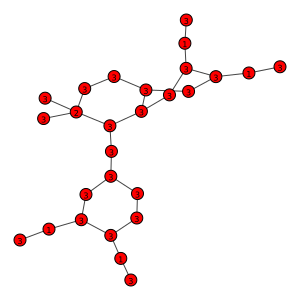

In [4]:
## subgraphs are easy to get
sg_no = 100
sg = G.subgraph(np.where(np.array(G.vs['graph']) == sg_no)[0].tolist())
ig.plot(sg, bbox=(300,300), vertex_size=12, vertex_label_size=8)

### Method 1 - Expander-based Vertex Features

For every "small" graphs, compute some features derived from expansion properties of vertices.



In [5]:
def get_sg_features(sg, depth=7):
    F = []
    n = sg.vcount()

    Deg = sg.degree()
    Lcc = sg.transitivity_local_undirected(mode='zero')
    Bet = np.array(sg.betweenness())/n**2
    Prk = sg.pagerank()
    #Lab = sg.vs['label']
    
    F.append(Deg)
    F.append(Lcc)
    F.append(Bet)
    F.append(Prk)
    #F.append(Lab)
    
    for i in range(depth):
        current = sg.neighborhood_size(order=i+1)
        F.append([i/n for i in current])
        if i>0:
            F.append([i / j for i, j in zip(current, previous)])
        previous = current
        F.append([np.mean([Deg[i] for i in x]) for x in sg.neighborhood(order=i+1)])
        F.append([np.mean([Lcc[i] for i in x]) for x in sg.neighborhood(order=i+1)])
        F.append([np.mean([Bet[i] for i in x]) for x in sg.neighborhood(order=i+1)])
        F.append([np.mean([Prk[i] for i in x]) for x in sg.neighborhood(order=i+1)])
        #F.append([np.mean([Lab[i] for i in x]) for x in sg.neighborhood(order=i+1)])
    F = np.array(F).transpose()
    return F

#### What we need:

* node_features: array (number of graphs) or arrays of size (number of vertices x number of features)
* graph_vertices: array (number of graphs) of lists of vertex names (unique, strings)


In [6]:
%%time
node_features = []
graphs_vertices = []
for i in list(set(G.vs['graph'])):
    sg = G.subgraph(np.where(np.array(G.vs['graph']) == i)[0].tolist())
    node_features.append(get_sg_features(sg, depth=10))
    graphs_vertices.append(np.array(sg.vs['name']))
node_features = np.array(node_features, dtype=object)
graphs_vertices = np.array(graphs_vertices, dtype=object)

CPU times: user 1min 26s, sys: 98.6 ms, total: 1min 26s
Wall time: 1min 26s


In [7]:
node_features[0].shape

(21, 63)

## Details TBD


In [8]:
vertex_vectors_0 = np.vstack(node_features)
vertex_vectors_0.shape

(122747, 63)

In [9]:
## list all vertex names, build ref dict
vertex_names = list(np.hstack(graphs_vertices))
vertex_names_dictionary = dict()
for i, v in enumerate(vertex_names):
    vertex_names_dictionary[v] = i    
n_vertices = len(vertex_names_dictionary)

In [10]:
%%time
## build graphs x vertices incidence given above ref dict
incidence_vectorizer = vectorizers.NgramVectorizer(
    token_dictionary=vertex_names_dictionary
).fit(graphs_vertices)

incidence_matrix = incidence_vectorizer.transform(graphs_vertices)

CPU times: user 2.19 s, sys: 76 ms, total: 2.26 s
Wall time: 2.26 s


In [11]:
incidence_matrix

<4110x122747 sparse matrix of type '<class 'numpy.float32'>'
	with 122747 stored elements in Compressed Sparse Row format>

In [12]:
vertex_vectors_0.shape

(122747, 63)

In [13]:
%%time
n_components = vertex_vectors_0.shape[0]
graph_awe_matrix_0 = vectorizers.ApproximateWassersteinVectorizer(
    normalization_power=0.66,
    n_components=n_components,
    random_state=42,
).fit_transform(incidence_matrix, vectors=vertex_vectors_0)
graph_awe_matrix_0.shape

CPU times: user 2min 6s, sys: 2min 58s, total: 5min 5s
Wall time: 1min 41s


(4110, 63)

In [14]:
%%time
vertex_vectors_norm_0 = normalize(vertex_vectors_0, axis=1, norm='l1')
n_components = vertex_vectors_norm_0.shape[0]
graph_awe_matrix_norm_0 = vectorizers.ApproximateWassersteinVectorizer(
    normalization_power=0.66,
    n_components=n_components,
    random_state=42,
).fit_transform(incidence_matrix, vectors=vertex_vectors_norm_0)
graph_awe_matrix_norm_0.shape

CPU times: user 2min 6s, sys: 3min 27s, total: 5min 33s
Wall time: 1min 55s


(4110, 63)

## Recursive part

as per VP's

In [15]:
node_incidence_matrix = G.get_adjacency_sparse()
node_incidence_matrix.setdiag(1) ## add self to neighbourhoods
#hyperedges_all = [ [str(int(G.vs[x]['name'])) for x in G.neighborhood(v)] for v in range(G.vcount())]


In [ ]:
vertex_awe_vectors = dict()
graph_awe_matrix = dict()
graph_awe_matrix_svd = dict()

number_iteration = 3

vertex_awe_vectors[0] = vertex_vectors_0
graph_awe_matrix[0] = graph_awe_matrix_0

vertex_awe_vectors[0] = normalize(vertex_awe_vectors[0], axis=1, norm='l1')
n_components = vertex_awe_vectors[0].shape[1]
svd = TruncatedSVD(n_components=n_components)

for i in range(1,number_iteration):
    vertex_awe_vectors[i] = vectorizers.ApproximateWassersteinVectorizer(
        normalization_power=0.66,
        random_state=42,
        # n_components=n_components
    ).fit_transform(node_incidence_matrix, vectors=vertex_awe_vectors[i-1])


    vertex_awe_vectors[i] = normalize(vertex_awe_vectors[i], axis=1, norm='l1')

    graph_awe_matrix[i] = vectorizers.ApproximateWassersteinVectorizer(
        random_state=42,
        # n_components=n_components,
        normalization_power=0.66,
    ).fit_transform(incidence_matrix, 
                    vectors=np.hstack([vertex_awe_vectors[i] for j in range(i+1)])
                   )
    
    graph_awe_matrix_svd[i] = svd.fit_transform(graph_awe_matrix[i])
    
    print(f'Interation {i}, shape of vector matrix {vertex_awe_vectors[i].shape}, shape of graph matrix {graph_awe_matrix[i].shape}')
    

vector_df = pd.DataFrame()
vector_df['groups'] = np.hstack(np.array([i]*vertex_awe_vectors[i].shape[0]) for i in range(number_iteration))
vector_df['lengths'] = np.hstack(np.linalg.norm(vertex_awe_vectors[i], axis=1, ord=1) for i in range(number_iteration))

In [ ]:
import pickle
with open('features_NCI1.pkl','wb') as fp:
    pickle.dump( (graph_awe_matrix_0,graph_awe_matrix_norm_0,
                  graph_awe_matrix[1],graph_awe_matrix[2],
                  graph_awe_matrix_svd[1],graph_awe_matrix_svd[2]), fp)
